# Import

In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

import torchvision.transforms as transforms

from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torch.autograd import Variable 

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
import torch.autograd as autograd

from pathlib import Path
import wandb

import time
_wandb = True
Load = True

In [ ]:
if _wandb:
    wandb.login()
    wandb.init(
        # set the wandb project where this run will be logged
        project="GAN-Z",
        
        # track hyperparameters and run metadata
        config={
        "learning_rate": 0.02,
        "architecture": "GAN",
        "dataset": "chr1",
        "epochs": 300,
        }

    )


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xbostick. Use `wandb login --relogin` to force relogin


In [2]:
cuda = True if torch.cuda.is_available() else False # GPU Setting

# Setting parametrs

In [3]:
generic = False # Generate generic data on the fly (ignores data_loc and data_start args)
data_loc = Path("./data/") # Data location
epoch = 300
disc_iters = 5 # Number of iterations to train discriminator for at each epoch
latent_dim = 5 # Size of latent space
gen_dim = 100 # Generator dimension parameter
disc_dim = 100 # Discriminator dimension parameter
gen_layers = 5
disc_layer = 5
batch_size = 100
max_seq_len = 1000

 gen_data = lib.models.resnet_generator(latent_vars, args.gen_dim, args.max_seq_len, data_enc_dim, args.annotate)
  data_enc_dim = 4

# Preparing DATASET

In [4]:
def ohe_DNA(part):
    seq = []
    for i in part:
        match i:
                case 0:
                    seq.append([1,0,0,0,0])
                case 1:
                    seq.append([0,1,0,0,0])
                case 2:
                    seq.append([0,0,1,0,0])
                case 3:
                    seq.append([0,0,0,1,0])
                case 4:
                    seq.append([0,0,0,0,1])
    return seq

In [5]:
def reverse_ohe_DNA(part):
    seq = []
    for i in part:
        match i:
                case [1,0,0,0,0]:
                    seq.append(0)
                case [0,1,0,0,0]:
                    seq.append(1)
                case [0,0,1,0,0]:
                    seq.append(2)
                case [0,0,0,1,0]:
                    seq.append(3)
                case [0,0,0,0,1]:
                    seq.append(4)
    return seq

In [6]:
dna_vocab = {"A":0,
             "C":1,
             "G":2,
             "T":3,
             "N":4} # catch-all auxiliary token

class GenomicData(Dataset):
    def __init__(self, path, seq_len):
        self.seq_len = seq_len
        with open(path) as fasta_file:  # Will close handle cleanly
            seq_record = {}
            seq_record["lengths"] = []
            seq_record["seq"] = []

            for seq_rec in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
                seq_record["lengths"].append(len(seq_rec.seq))
                seq_record["seq"].append(seq_rec.seq)
        self.len = int(seq_record["lengths"][0])
        self.coded_seq = []
        for one in list(seq_record["seq"][0]):
            try:
                self.coded_seq.append(dna_vocab[one.upper()])
            except:
                print(one)

    def __len__(self):
        return int(self.len/self.seq_len)#int(np.round((self.len - self.seq_len)/100))
    
    def __getitem__(self, idx):
        return torch.Tensor(ohe_DNA(self.coded_seq[idx* self.seq_len:(idx+1)*self.seq_len]))


GenData = GenomicData("./data/chr1.fa", max_seq_len)

In [9]:
GenData[1].shape

torch.Size([1000, 5])

# Structure of NNs

6 сверточных слоев с skip connection residual factor 0.3.
В сверточном слое 100 фильтров ядро 5 stribe 1
adam optimazer и wasserstein loss(WGAN) and lr 1e-5

In [7]:
import torch.nn as nn
import torch.functional as F

In [8]:
class Generator_new(nn.Module):
    def __init__(self,  latent_vars, gen_dim, max_seq_len, annotated=False, res_layers=5):
        super(Generator_new, self).__init__()
        self.input_size = latent_vars.shape
        self.output_size = gen_dim * max_seq_len
        self.seq_len = max_seq_len
        self.gen_dim = gen_dim
        self.res_layer = res_layers
        #self.conv1 = nn.Conv1d(3,6,5,1)
        self.con1 = nn.Conv1d(gen_dim ,gen_dim,5,1, padding = 'same')
        self.con2 = nn.Conv1d(gen_dim ,gen_dim,5,1, padding = 'same')
        self.con3 = nn.Conv1d(gen_dim ,gen_dim,5,1, padding = 'same')
        self.con4 = nn.Conv1d(gen_dim ,gen_dim,5,1, padding = 'same')
        self.con5 = nn.Conv1d(gen_dim ,gen_dim,5,1, padding = 'same')
        self.conv1 = nn.Sequential(
                        nn.Conv1d(gen_dim,5,5,1, padding = 'same'),
                        nn.ReLU())
        # self.con_array = [
        #     self.con1,
        #     self.con2,
        #     self.con3,
        #     self.con4,
        #     self.con5,
        # ]
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()#nn.Sigmoid()
        self.linear = nn.Linear(1,100)
        

    def forward(self,x):
        x = torch.transpose(x, 0, 1)
        x = self.linear(x) 
        x = torch.transpose(x , 0, 1)
        _input = x
        
        out = self.con1(_input)
        out = _input + 0.3 * out
        _input = self.relu(out)
        
        out = self.con2(_input)
        out = _input + 0.3 * out
        _input = self.relu(out)

        out = self.con3(_input)
        out = _input + 0.3 * out
        _input = self.relu(out)

        out = self.con4(_input)
        out = _input + 0.3 * out
        _input = self.relu(out)

        out = self.con5(_input)
        out = _input + 0.3 * out
        _input = self.relu(out)

        output = self.conv1(_input)
        output = torch.transpose(output, 0, 1)
        output = self.softmax(output)
        output = torch.transpose(output, 0, 1)
        return output

In [9]:
class Critical_new(nn.Module):
    def __init__(self,  latent_vars, gen_dim, max_seq_len, annotated=False, res_layers=5):
        super(Critical_new, self).__init__()
        self.input_size = latent_vars.shape
        self.output_size = gen_dim * max_seq_len
        self.seq_len = max_seq_len
        self.gen_dim = gen_dim
        self.res_layer = res_layers
        #self.conv1 = nn.Conv1d(3,6,5,1)
        self.con1 = nn.Conv1d(gen_dim ,gen_dim,5,1, padding = 'same')
        self.con2 = nn.Conv1d(gen_dim ,gen_dim,5,1, padding = 'same')
        self.con3 = nn.Conv1d(gen_dim ,gen_dim,5,1, padding = 'same')
        self.con4 = nn.Conv1d(gen_dim ,gen_dim,5,1, padding = 'same')
        self.con5 = nn.Conv1d(gen_dim ,gen_dim,5,1, padding = 'same')
        self.conv1 = nn.Sequential(
                        nn.Conv1d(5, gen_dim,5,1, padding = 'same'),
                        nn.ReLU())
        # self.con_array = [
        #     self.con1,
        #     self.con2,
        #     self.con3,
        #     self.con4,
        #     self.con5,
        # ]
        self.relu = nn.ReLU()
        self.linear = nn.Linear(100,1)
        # self.sigmoid = nn.Sigmoid()


    def forward(self,x):
        _input = self.conv1(x)
        
        out = self.con1(_input)
        out = _input + 0.3 * out
        _input = self.relu(out)

        out = self.con2(_input)
        out = _input + 0.3 * out
        _input = self.relu(out)

        out = self.con3(_input)
        out = _input + 0.3 * out
        _input = self.relu(out)

        out = self.con4(_input)
        out = _input + 0.3 * out
        _input = self.relu(out)

        out = self.con5(_input)
        out = _input + 0.3 * out
        _input = self.relu(out)

        output = torch.transpose(_input, 0, 1)
        output = self.linear(output)
        output = torch.transpose(output, 0, 1)
        return output


In [10]:
num_classes = 10
num_epochs = 20
batch_size = 16
learning_rate = 0.01

In [11]:
latent_vars = torch.randn([10,10])

In [12]:
generator= Generator_new(latent_vars,gen_dim,max_seq_len)
discriminator = Critical_new(latent_vars,gen_dim,max_seq_len)

In [220]:
if Load:
    generator.load_state_dict(torch.load("./models/generator.mod"))
    generator.eval()

    discriminator.load_state_dict(torch.load("./models/discriminator.mod"))
    discriminator.eval()

In [17]:
# generator.cuda()
# out = generator(z)
# discriminator.cuda()
# discriminator(out).size()

In [14]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    #adversarial_loss.cuda()

_____

In [19]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 1e-4

In [20]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas = (b1,b2) )
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (b1,b2))

____

In [73]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [22]:
if _wandb:
    wandb.watch(generator, log_freq=100)
    wandb.watch(discriminator, log_freq=100)

In [23]:
def reset_grad(model):
    for param in model.parameters():
        param.grad = None


In [24]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1)))
        # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    d_interpolates = discriminator(interpolates)
    fake = Variable(Tensor(1,1000).fill_(1.0), requires_grad=False)
        # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [25]:
def WandbLogging(LogData,StartTime, Delay):
    NowTime = time.perf_counter()
    if NowTime - StartTime > Delay:
        wandb.log(LogData)
        return NowTime
    else:
        return StartTime

In [26]:
from IPython.display import clear_output

In [ ]:
clear_output()
n_epochs = 10 # suggested default = 200
for epoch in range(n_epochs):
    dataloader = None
    dataloader = DataLoader(GenData,6,drop_last=True, shuffle = True)
    StartTime = time.perf_counter()
    for i in tqdm(dataloader):
        train_data = i.cuda()
        #   Critical forward-loss-backward-update
        for j in range(5):

            # Sample data
            noise = Variable(torch.randn((1,1000))).cuda()# Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        
            # real_data = torch.reshape(train_data[j],(1,1000))
            real_data = torch.transpose(train_data[j],0,1)
            real_data = Variable(real_data)

            #generic
            fake_data = generator(noise)
            critics_real = discriminator(real_data)
            critics_fake = discriminator(fake_data)

            gradient_penalty = compute_gradient_penalty(discriminator, real_data, fake_data)
            critics_loss = -torch.mean(critics_real) + torch.mean(critics_fake) + 10 * gradient_penalty
            
            critics_loss.backward()
            optimizer_D.step()

            # Weight clipping
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)

            # Housekeeping - reset gradient
            reset_grad(generator)
            reset_grad(discriminator)

        #   Generator forward-loss-backward-update
        
        noise = Variable(torch.randn((1,1000))).cuda()# Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        #real_data = torch.reshape(train_data[j+1],(1,1000))
        real_data = Variable(real_data)
        #real_data = imgs["generator"].type(Tensor)

        fake_data = generator(noise)
        critics_fake = discriminator(fake_data)

        generator_loss = -torch.mean(critics_fake)
        
        generator_loss.backward()
        optimizer_G.step()

        # Housekeeping - reset gradient
        reset_grad(generator)
        reset_grad(discriminator)

        if _wandb:
            table = wandb.Histogram(np_histogram = np.histogram(np.argmax(generator(noise).detach().cpu().numpy(),0)))
            WandbLogDict = {"Epoch": epoch+1, "Critics_loss": critics_loss.item(), "Generator_loss": generator_loss.item(),"Results": table}
            StartTime = WandbLogging(WandbLogDict, StartTime, 120)
            

    print('D_loss: {}; G_loss: {}'
              .format(critics_loss.item(),  generator_loss.item()))


In [28]:
wandb.finish()

Critics_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅███████████
Generator_loss,█▇▁▄█▆▇▇▆▅▄▄▄▃▅▃▅▄▄▄▄▆▅▂▄▃▆▆▅▄▃▅▄▂▇▅▅▅▆▇
Critics_loss,-0.00391
Epoch,3
Generator_loss,-0.03669


In [29]:
torch.save(generator.state_dict(), "./models/generator1.mod")
torch.save(discriminator.state_dict(), "./models/discriminator1.mod")

In [15]:
def generate_seq(generator):
    noise = Variable(torch.randn((1,1000))).cuda()
    OheSeq = generator(noise).detach().cpu().numpy()
    return np.argmax(OheSeq,0)

In [211]:
dna_vocab_revers = {0: "A",
             1:"C",
             2:"G",
             3:"T",
             4:"N"}
def Gseq2file(seq):
    wr = []
    for i in seq:
        wr.extend(dna_vocab_revers[i])
    with open("./check.txt", 'w+') as f:
        f.write(wr)

In [221]:
wr = []
seq = generate_seq(generator)
for i in seq:
        wr.extend(dna_vocab_revers[i])
with open("./check.txt", 'w+') as f:
        f.write(''.join(wr))

C:\Temp\ipykernel_6340\752960707.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


# Metrics

In each sequence, the model recapitulated
not only the properties related to basic sequence composition, such as


GC content (Fig. 2c: average GC content within 1.1% of values in natural
sequences) and 

UTR sizes (Fig. 2d, e: average length of generated UTRs
within 8 bp of natural ones) but also the known 

DNA regulatory grammar (see Fig. 1a). 

This included (i) canonical motifs of transcription factor binding sites (TFBS) from the Jaspar database48, 

identified (qvalue < 0.05) using FIMO49, and 

core promoter elements comprising the TATA box50,51 in promoters (ii) Kozak sequences in 5′ UTRs52,53, (iii) termination related motifs, including positioning, efficiency, and poly-AT
motifs6,54 in 3′ UTRs and terminators, (iv) previous deep learninguncovered expression-related motifs and motif associations7, as well as
(v) positions predicted to be depleted of nucleosome

## GC content

In [18]:
def GC_Content(ohe_seq):
    return (sum(ohe_seq == dna_vocab["G"]) + sum(ohe_seq == dna_vocab["C"]))/len(ohe_seq)

In [55]:
dataloader = DataLoader(GenData,1,drop_last=True, shuffle = True)

In [208]:
real = []
gen = []
for num,batch in tqdm(enumerate(dataloader)):
    real.append(GC_Content(np.array(reverse_ohe_DNA(batch[0].tolist()))))
    gen.append(GC_Content(generate_seq(generator)))
    if num >= 1000:
        break
print(np.mean(real))
print(np.mean(gen))

0it [00:00, ?it/s]

C:\Temp\ipykernel_6340\752960707.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


0.3855094905094905
0.3542147852147852


## Kozak seq


In [84]:
swap_dna_vocab =   {0:0,
                    1:3,
                    2:2,
                    3:1,
                    4:4}

def ohe_swap(seq):
    swaped = []
    for i in seq:
        swaped.append(swap_dna_vocab[i])
    return swaped

In [85]:
#Kozak Consensus Scoring System

#0=A, 1=T, 2=G, 3=C, 4=N (Missing)
weights = np.array([
       [0.04210526, 0.        , 0.03157895, 0.05263158, 0.        ],
       [0.04210526, 0.05263158, 0.10526316, 0.0625    , 0.        ],
       [0.03157895, 0.04210526, 0.05263158, 0.07368421, 0.        ],
       [0.03157895, 0.01052632, 0.04210526, 0.05263158, 0.        ],
       [0.08421053, 0.07368421, 0.18947368, 0.10526316, 0.        ],
       [0.04210526, 0.05263158, 0.05263158, 0.08421053, 0.        ],
       [0.12631579, 0.0625    , 0.12631579, 0.21052632, 0.        ],
       [0.83157895, 0.12631579, 0.65263158, 0.16842105, 0.        ],
       [0.15789474, 0.06315789, 0.11578947, 0.2       , 0.        ],
       [0.21052632, 0.09473684, 0.31578947, 0.51578947, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.24210526, 0.16666667, 0.53684211, 0.13684211, 0.        ],
       [0.15789474, 0.09473684, 0.09473684, 0.24210526, 0.        ],
       [0.05263158, 0.08421053, 0.14736842, 0.09473684, 0.        ],
       [0.07216495, 0.05263158, 0.10526316, 0.06315789, 0.        ],
       [0.        , 0.        , 0.        , 0.05263158, 0.        ],
       [0.05263158, 0.05263158, 0.10526316, 0.09473684, 0.        ],
       [0.04210526, 0.03157895, 0.05263158, 0.04210526, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.04210526, 0.04210526, 0.08421053, 0.07368421, 0.        ],
       [0.0625    , 0.04210526, 0.09473684, 0.05263158, 0.        ]
])

#Below function scores using consensus kozak motif scores
def similarity_score(sequence):
                
    #We need consistency and flexibility:
        
    numbers = ohe_swap(sequence)
                
    
    score = 0
    for k in np.arange(len(numbers)):
        score += weights[k][numbers[k]]
            
    max_score = np.sum(weights.max(axis=1))
    
    score = score/max_score
    
    #Final scoring value: we take the maximum possible score 
    #calculated, and return our score divided by the maximum (to normalize from range 0 to 1) 
    
    return(score)

C:\Temp\ipykernel_6340\752960707.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


(array([ 8793.,     0.,     0.,  1723., 17101., 22599., 26331., 17523.,
         5062.,   522.]),
 array([0.        , 0.09211268, 0.18422535, 0.27633803, 0.3684507 ,
        0.46056338, 0.55267606, 0.64478873, 0.73690141, 0.82901409,
        0.92112676]),
 <BarContainer object of 10 artists>)

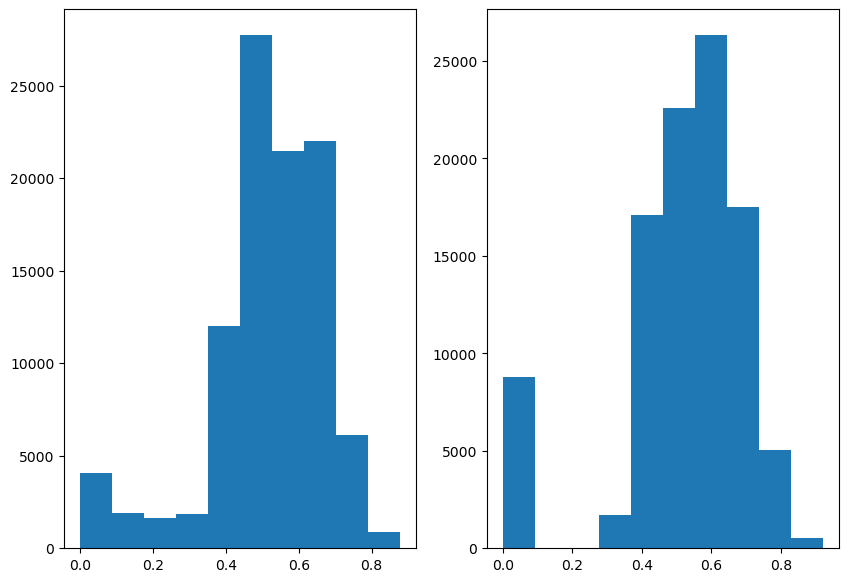

In [225]:
G_s = []
R_s = []
for num,batch in enumerate(dataloader):
    G_seq = generate_seq(generator)
    R_seq = np.array(reverse_ohe_DNA(batch[0].tolist()))
    for i in range(1000-23):
        G_s.append(similarity_score(G_seq[i:i+23]))
        R_s.append(similarity_score(R_seq[i:i+23]))
    if num > 100:
        break

fig = plt.figure(figsize=(10, 7))
columns = 2
rows = 1
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
plt.hist(G_s)

fig.add_subplot(rows, columns, 2)
plt.hist(R_s)


In [227]:
from scipy import stats
stats.kstest(G_s,R_s)

KstestResult(statistic=0.08478335039235756, pvalue=4.77338769689e-312, statistic_location=0.0, statistic_sign=-1)